### Airline Tweets Sentiment Analysis Final Report

Many Twitter users tweet about there travel experiences, particularly with regard to Airlines, and the service they received on particular airlines. This can have an influence on the future purchase decisions of potential passengers, so it is important for Airline management to know how its Airline is perceived on Twitter.

The objective is to build a model than can analyses the sentiment of a tweet. That way a Website can be built around the model which can get a quantative information on an airlines twitter perception over a time period and examine the trend of that perception.



## The Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import re
import string
import emoji
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
file_path = 'data/Tweets.csv'
df = pd.read_csv(file_path,sep=',')

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Cleaning the Data



In [5]:
# Find if any columns have null values
null_counts = df.isnull().sum()
# Print the result
null_counts

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [6]:
# Dropping Columns that have null values As it is they are unnecceary columns. Also dropping unneeded tweet metadata such as name, tweet geolocation, 
# tweet time and retweet count 
df = df.drop(columns=[
    'tweet_id', 'negativereason',
    'negativereason_confidence', 'airline_sentiment_gold', 'name',
    'negativereason_gold', 'tweet_coord', 'tweet_location',
    'user_timezone', 'tweet_created', 'retweet_count'
])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline_sentiment_confidence  14640 non-null  float64
 2   airline                       14640 non-null  object 
 3   text                          14640 non-null  object 
dtypes: float64(1), object(3)
memory usage: 457.6+ KB


It makes no sense that we could be training from data where the confidence level of the sentiment is not high. So I will drop every row where sentiment confidence level less than 0.7. Then I will drop the sentiment column, and ensure that there are no null values in the text column.

In [7]:
df = df[df['airline_sentiment_confidence'] >= 0.7]
df = df.drop(columns=['airline_sentiment_confidence'])
df.dropna(subset=['text'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10768 entries, 0 to 14638
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  10768 non-null  object
 1   airline            10768 non-null  object
 2   text               10768 non-null  object
dtypes: object(3)
memory usage: 336.5+ KB


In [8]:
# Confirm that there are only 3 sentiment values in the dataset
df['airline_sentiment'].value_counts()

airline_sentiment
negative    7552
neutral     1634
positive    1582
Name: count, dtype: int64

Interesting to note that the negative sentiment greatly outnumbers the neutral and positive tweets. Indicates that people are much more likely to tweet negatively than positively. Not a balanced dataset, heavily skewed towards negative.

### Visualizing the Data
Here is a breakdown of the sentiment for each airline in pie charts.

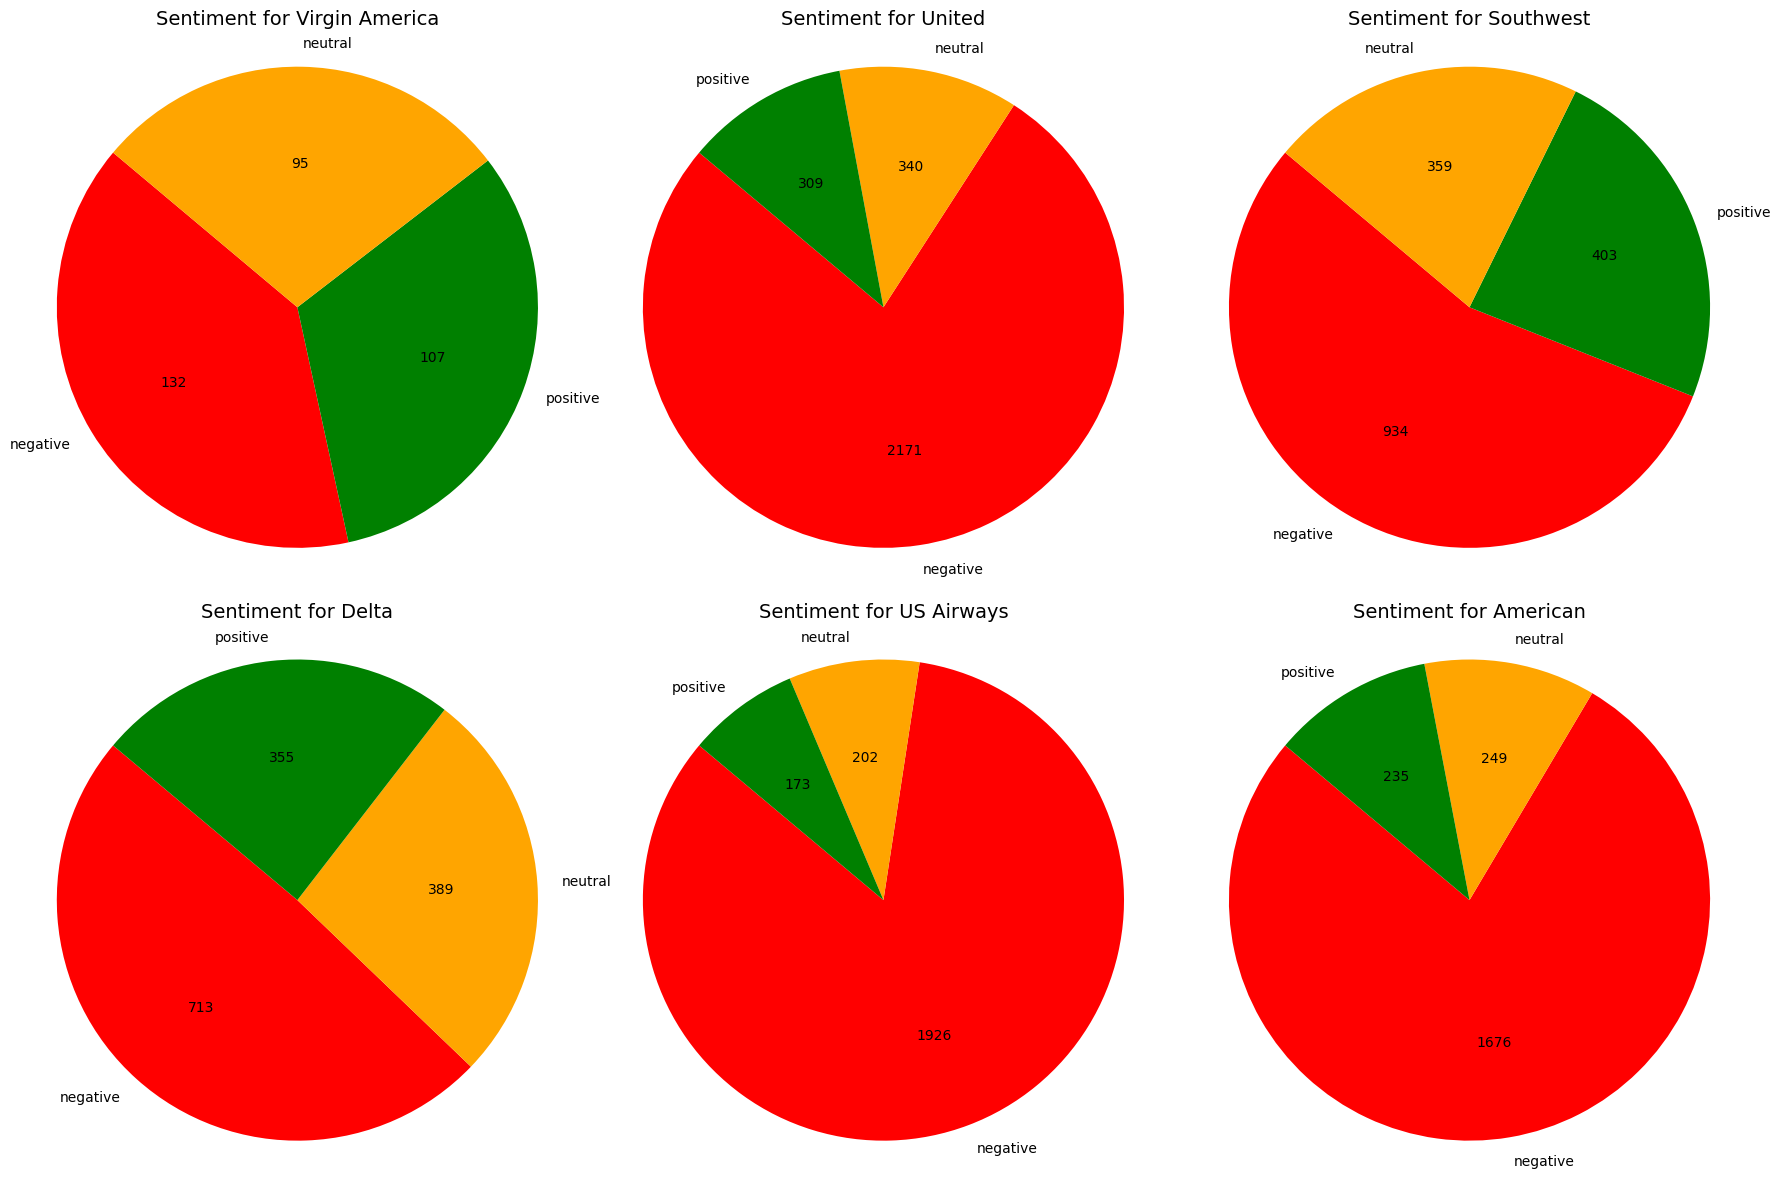

In [9]:

# Get unique airlines
airlines = df['airline'].unique()
num_airlines = len(airlines)

# Set number of columns (3 charts per row)
cols = 3
rows = math.ceil(num_airlines / cols)

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
axes = axes.flatten()

# Define sentiment colors
sentiment_color_map = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'orange'
}

# Function to label slices with absolute counts
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}'
    return my_autopct

# Generate pie charts
for i, airline in enumerate(airlines):
    ax = axes[i]
    airline_data = df[df['airline'] == airline]
    sentiment_counts = airline_data['airline_sentiment'].value_counts()

    labels = sentiment_counts.index.tolist()
    sizes = sentiment_counts.values.tolist()
    colors = [sentiment_color_map[label] for label in labels]

    ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct=make_autopct(sizes),
        startangle=140,
        textprops={'fontsize': 10}
    )
    ax.axis('equal')
    ax.set_title(f"Sentiment for {airline}", fontsize=14)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("airline_sentiment_pie_charts.jpg", dpi=300, bbox_inches='tight')
plt.show()

### Pre-processing
Need to pre-process that Text in order to make it suitable for modelling.

In [10]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Tokenizer and lemmatizer setup
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = emoji.demojize(text)
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in string.punctuation]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Copy relevant columns
df_preprocessed = df[['airline_sentiment', 'airline', 'text']].copy()

# Tokenize and preprocess
df_preprocessed['tokens'] = df_preprocessed['text'].apply(preprocess_text)

# Convert tokens to space-separated strings for vectorization
df_preprocessed['processed_text'] = df_preprocessed['tokens'].apply(lambda tokens: ' '.join(tokens))

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_preprocessed['processed_text'])

# One-hot encode airline column
encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False if you're using older versions of sklearn
X_airline = encoder.fit_transform(df_preprocessed[['airline']])

# Combine TF-IDF and airline features
from scipy.sparse import hstack
X_combined = hstack([X_tfidf, X_airline])

# Map sentiment labels to integers
sentiment_map = {'positive': 2, 'negative': 0, 'neutral': 1}
df_preprocessed['label'] = df_preprocessed['airline_sentiment'].map(sentiment_map)

# Final label and features
y = df_preprocessed['label']
X = X_combined


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DNIALL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DNIALL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DNIALL\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Modeling

Make the Train/Test Split

In [11]:


# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = []
    
    # Binarize the labels for multiclass AUC computation
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Accuracy scores
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        # AUC computation (supports predict_proba or decision_function)
        try:
            if hasattr(model, "predict_proba"):
                y_probs = model.predict_proba(X_test)
            else:
                y_probs = model.decision_function(X_test)

            auc_score = roc_auc_score(y_test_bin, y_probs, average='macro', multi_class='ovr')
        except Exception as e:
            print(f"AUC calculation failed for {name}: {e}")
            auc_score = None

        # Store results
        results.append([name, train_time, train_acc, test_acc, auc_score])

    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy", "AUC Score"])

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].bar(results_df['Model'], results_df['Train Accuracy'], color='skyblue')
    axes[0].set_title('Train Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].tick_params(axis='x', rotation=45)

    axes[1].bar(results_df['Model'], results_df['Test Accuracy'], color='lightgreen')
    axes[1].set_title('Test Accuracy')
    axes[1].set_ylabel('Accuracy')
    axes[1].tick_params(axis='x', rotation=45)

    axes[2].bar(results_df['Model'], results_df['AUC Score'], color='salmon')
    axes[2].set_title('AUC Score')
    axes[2].set_ylabel('AUC')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("model bar charts.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    return results_df

Training LogRegress...
Training KNN...
Training Decision Tree...
Training SVC...
Training Naive Bayes...
Training Random Forest...
Training Neural Net...


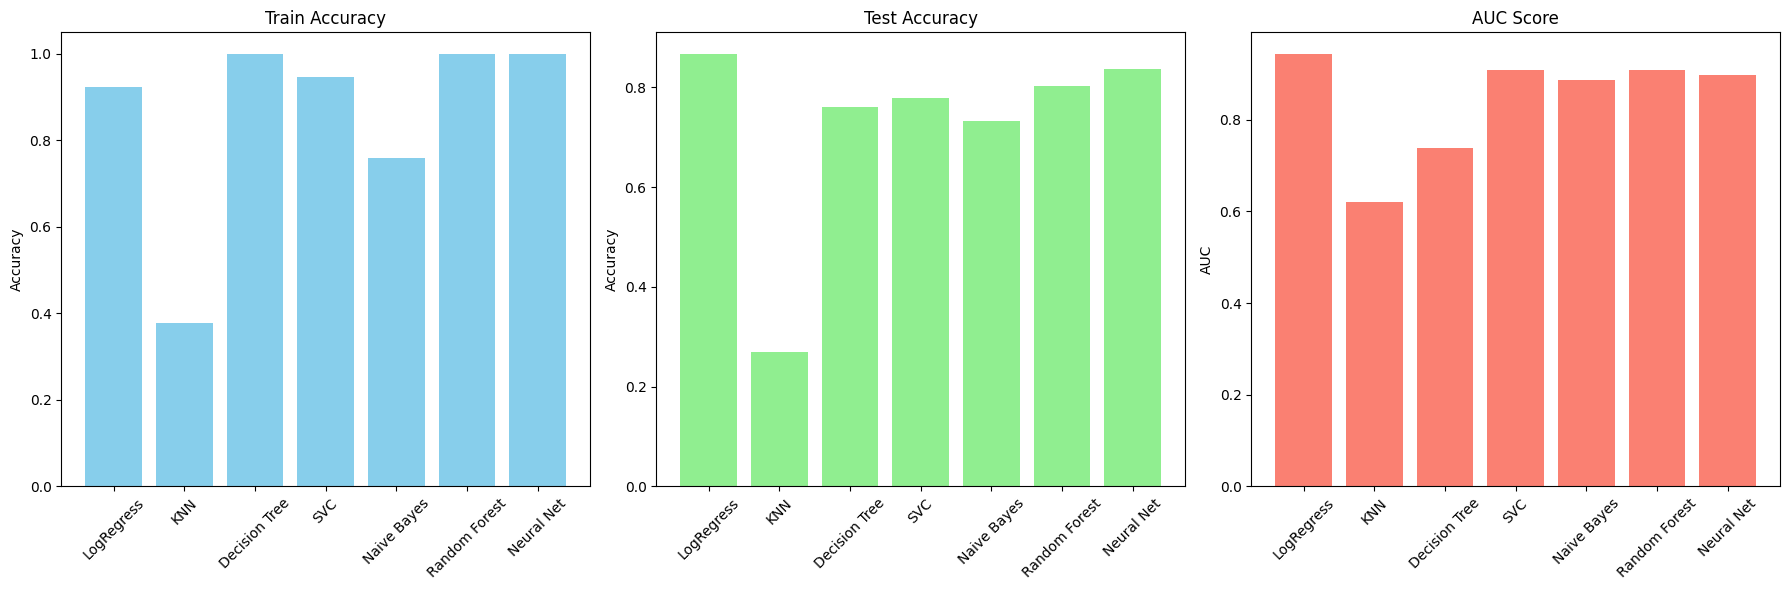

           Model  Train Time  Train Accuracy  Test Accuracy  AUC Score
0     LogRegress    1.068357        0.923264       0.867224   0.943287
1            KNN    0.007240        0.378570       0.269266   0.621423
2  Decision Tree    3.433178        0.999303       0.761374   0.737086
3            SVC  135.185673        0.944973       0.778552   0.908386
4    Naive Bayes    0.000000        0.758649       0.732126   0.886241
5  Random Forest   29.060554        0.999303       0.803621   0.907840
6     Neural Net  241.408214        0.999303       0.836583   0.896468


In [13]:
#

models = {
    "LogRegress": LogisticRegression(solver='lbfgs', max_iter=1000),
    "KNN": make_pipeline(StandardScaler(with_mean=False), KNeighborsClassifier()),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVC": make_pipeline(StandardScaler(with_mean=False), SVC(probability=True)),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Neural Net": make_pipeline(StandardScaler(with_mean=False), MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
}

    
# Example usage
results_df = evaluate_models(X_train, X_test, y_train, y_test, models)
print(results_df)

## Improving the Model



##### Questions